# Tâche 9 : Densité de phonons 

In [1]:
import numpy as np
from mp_api.client import MPRester
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from math import pi

In [2]:
mp_key = "MgnCbwKILRoKeWCsa2tbfn04aBTHkB78"
mp_id = "mp-1747"

In [3]:
with MPRester(mp_key) as m:
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    prim_struc = m.get_structure_by_material_id(mp_id)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Température de Debye et de Einstein 

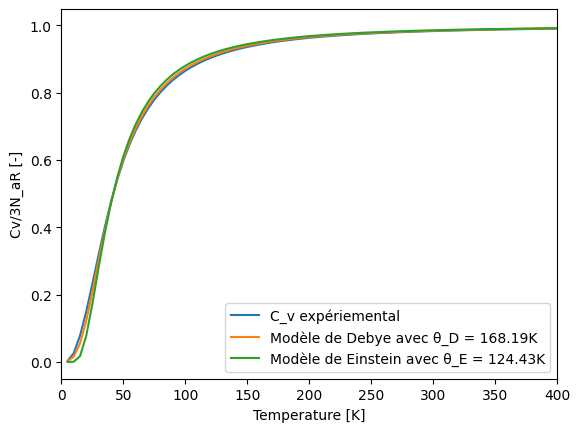

In [11]:
#Constantes

nat = len(prim_struc)
frequencies = ph_dos.frequencies
density = ph_dos.densities
boltzmann = 1.380649 * 10** (-23)
hbar = 6.626 * 10 ** (-34) / (2*np.pi)
volume = prim_struc.volume * 10**(-30)
q_d = (6*np.pi*np.pi/volume)**(1/3)


#Chaleur spécifique et Température

T = np.arange(5,1000,5)
Cv = np.array([ph_dos.cv(T[i]) for i in range(len(T))])/(3*nat*8.314)


# Modèle de Debye
def debye(T, ThetaD):
    def f(x):
        return x**4 * np.exp(x) / (np.exp(x) - 1)**2
    integrals = []
    for t in T:
        integral, error = quad(f, 0.0000001, ThetaD/t)
        integrals.append(integral)
    return 3 * (T/ThetaD)**3 * np.array(integrals)

# Modèle d'Einstein
def einstein(T, ThetaE):
    return (ThetaE / T)**2 * np.exp(ThetaE / T) / (np.exp(ThetaE / T) - 1)**2


# Ajuster les modèles
popt_debye, _ = curve_fit(debye, T, Cv)
popt_einstein, _ = curve_fit(einstein, T, Cv)

# Prédictions des modèles
Cv_debye = debye(T, *popt_debye)
Cv_einstein = einstein(T, *popt_einstein)


# Tracer les données et les prédictions des modèles
plt.plot(T, Cv, label='C_v expériemental')
plt.plot(T, Cv_debye, label='Modèle de Debye avec θ_D = ' + str(round(popt_debye[0], 2)) + 'K')
plt.plot(T, Cv_einstein, label='Modèle de Einstein avec θ_E = ' + str(round(popt_einstein[0], 2)) + 'K')
plt.legend()
axes = plt.gca()
axes.set_xlim (0, 400)
plt.xlabel('Temperature [K]')
plt.ylabel('Cv/3N_aR [-]')
plt.show()


Nous pouvons voir sur le graphe ci-dessus que le modèle de Einstein est une moins bonne approximation à basse température que celui de Debye. 

## Densité d'états des phonons

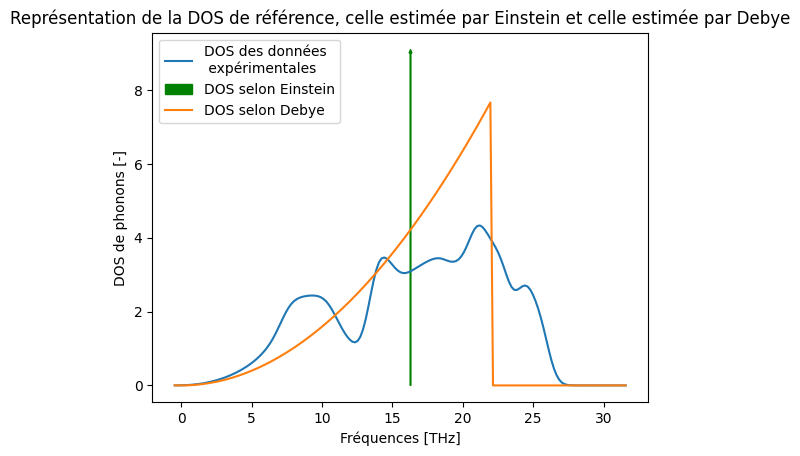

Nous pouvons voir, sur le graphe ci-dessus, la densité des états des phonons selon 
le modèle d'Einstein et de Debye. Le modèle d'Einstein corrrespond en un delta de Dirac 
positionné à la fréquence d'Einstein : 16.29 THz et de norme égale à 
3 * Nombre d'atomes de la cellule primitive. 
Celui de Debye est une courbe quadratique avec une fréquence de coupure égale à la fréquence de Debye : 22.02 THz.


Nous pouvons vérifier la précison des modèles en comparant les aires sous les différentes courbes qui doivent être égale peut importe la représentation. 
Nous pouvons voir que c'est bel et bien le cas ici : 

Aire sous la courbe des données expérimentales : 8.99998145051665
Aire sous la courbe du modèle de Debye : 9.042387758161658
Aire sous la courbe du modèle d'Einstein : 9
Erreur Debye : 0.04240630764500786
Erreur de Einstein : 1.8549483350227547e-05


In [5]:

fd = (popt_debye[0] * boltzmann) /hbar *10**-12
fe = (popt_einstein[0] * boltzmann) /hbar *10**-12

donnees = np.zeros(len(frequencies))

for i in range(len(frequencies)):
    w = frequencies[i] * 2*np.pi
    if w < fd:
        donnees[i] = (2*np.pi*3*nat*volume*w*w*q_d**3)/(2*(np.pi**2)*fd**3)


    else:
        donnees[i] = 0

# Tracer les données
plt.plot(frequencies* 2* np.pi, density, label="DOS des données \n expérimentales")

plt.arrow(fe, 0, 0, 3*nat, width=0.05, head_width=0.2, head_length=0.1, fc='green', ec= 'green', label = "DOS selon Einstein")
          
plt.plot(frequencies*2*np.pi, donnees, label = "DOS selon Debye")
plt.title("Représentation de la DOS de référence, celle estimée par Einstein et celle estimée par Debye")
plt.ylabel('DOS de phonons [-]')
plt.xlabel('Fréquences [THz]')
plt.legend()
plt.show()

print("Nous pouvons voir, sur le graphe ci-dessus, la densité des états des phonons selon \nle modèle d'Einstein et de Debye. Le modèle d'Einstein corrrespond en un delta de Dirac \npositionné à la fréquence d'Einstein : {0} THz et de norme égale à \n3 * Nombre d'atomes de la cellule primitive. \nCelui de Debye est une courbe quadratique avec une fréquence de coupure égale à la fréquence de Debye : {1} THz.".format(round(fe, 2),round(fd, 2)))

print("\n\nNous pouvons vérifier la précison des modèles en comparant les aires sous les différentes courbes qui doivent être égale peut importe la représentation. \nNous pouvons voir que c'est bel et bien le cas ici : \n")
# Calcul des aires.
e = 3*nat
ex = 0
de = 0
for i in range(len(frequencies)-1) : 
    ex += (density[i])*(frequencies[i+1] - frequencies[i])
    de += (donnees[i])*(frequencies[i+1] - frequencies[i])
print("Aire sous la courbe des données expérimentales : " + str(ex))
print("Aire sous la courbe du modèle de Debye : " + str(de))
print("Aire sous la courbe du modèle d'Einstein : " + str(e))
print("Erreur Debye : " + str(de-ex))
print("Erreur de Einstein : " +str(e-ex))


## Analyse des résultats 

1) Le modèle de Einstein 

Tous les atomes vibrent selon la même fréquence de vibration notée $\omega_E$. Cette fréquence se calcule via : $\omega_E = \frac{k_b\Theta_E}{\hbar}$ avec $k_b = 1.380649 * 10^{-23}$, la constante de Boltzmann et $\Theta_E$ la température de Einstein. Cette température peut être calculée grâce au modèle de Einstein qui dit que : 

$C_V = 3N_{at}R\left(\frac{\Theta_E}{T}\right)^2 \frac{e^{\frac{\Theta_E}{T}}}{(e^{\frac{\Theta_E}{T}} - 1)^2}$

La présence du facteur $3N_{at}$ indique que nous prenons chaque atome de la maille primitive et que nous les multiplions par le nombre de mode de vibration permis (3 en 3D).


2) Le modèle de Debye 

Le modèle prend pour hypothèse une dispersion linéaire des fréquences de vibration des atomes du cristal. Chaque atomes possèdent donc une fréquence propre différente. La loi de dispersion est : $\omega(q) = vq$ avec q qui est le vecteur d'onde des phonons et v est la vitesse de l'onde. Nous pouvons de nouveau lier une fréquance à une température : $\omega_D = \frac{k_b\Theta_D}{\hbar}$ et nous calculons $\Theta_D$, la température de Debye grâce au modèle de Debye : 

$C_V = 9N_{at}R\left(\frac{T}{\Theta_D}\right)^3 \int_0^{\Theta_D/T} \frac{x^4 e^x}{(e^x - 1)^2} dx$

